In [1]:
import os
import sys

sys.path.append("..")

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn

import models

from py_utils.src import utils_img, utils_torch

---
new data

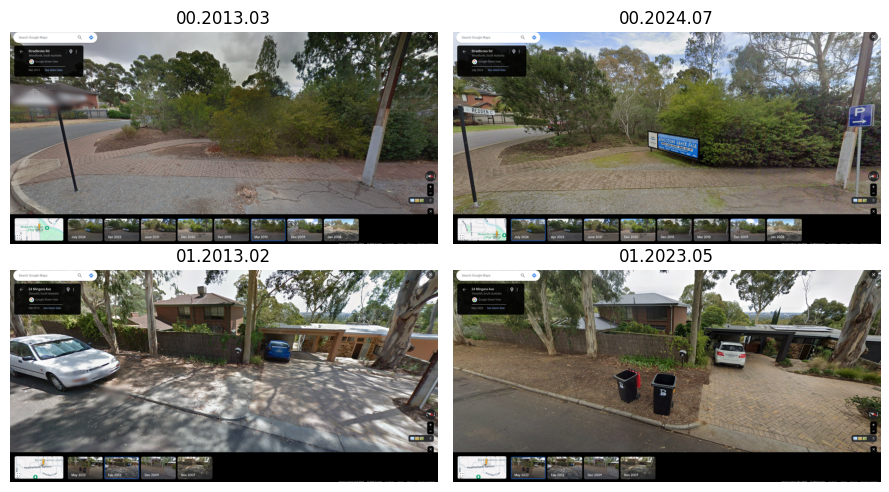

In [3]:
root = "./google_map_screenshots"

t0_0 = plt.imread(os.path.join(root, "00.2013.03.png"))[..., :3]
t1_0 = plt.imread(os.path.join(root, "00.2024.07.png"))[..., :3]

t0_1 = plt.imread(os.path.join(root, "01.2013.02.png"))[..., :3]
t1_1 = plt.imread(os.path.join(root, "01.2023.05.png"))[..., :3]

fig, ax = plt.subplots(2, 2, figsize=(9, 5))

ax[0, 0].imshow(t0_0)
ax[0, 1].imshow(t1_0)
ax[1, 0].imshow(t0_1)
ax[1, 1].imshow(t1_1)

ax[0, 0].set_title("00.2013.03")
ax[0, 1].set_title("00.2024.07")
ax[1, 0].set_title("01.2013.02")
ax[1, 1].set_title("01.2023.05")

# remove axis
for a in ax.ravel():
    a.axis("off")

plt.tight_layout()

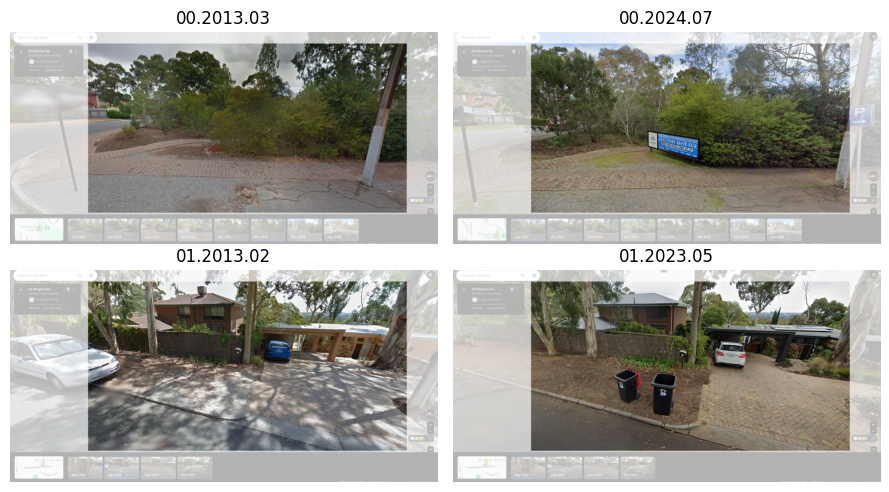

In [4]:
roi = np.load(os.path.join(root, "roi.npy"))

kwargs = {
    "layer": [1, 1, 1],  # white color
    "ratio": 0.3,
    "mask": roi,
}

fig, ax = plt.subplots(2, 2, figsize=(9, 5))

ax[0, 0].imshow(utils_img.overlay_image(t0_0, **kwargs))
ax[0, 1].imshow(utils_img.overlay_image(t1_0, **kwargs))
ax[1, 0].imshow(utils_img.overlay_image(t0_1, **kwargs))
ax[1, 1].imshow(utils_img.overlay_image(t1_1, **kwargs))

ax[0, 0].set_title("00.2013.03")
ax[0, 1].set_title("00.2024.07")
ax[1, 0].set_title("01.2013.02")
ax[1, 1].set_title("01.2023.05")

# remove axis
for a in ax.ravel():
    a.axis("off")

plt.tight_layout()

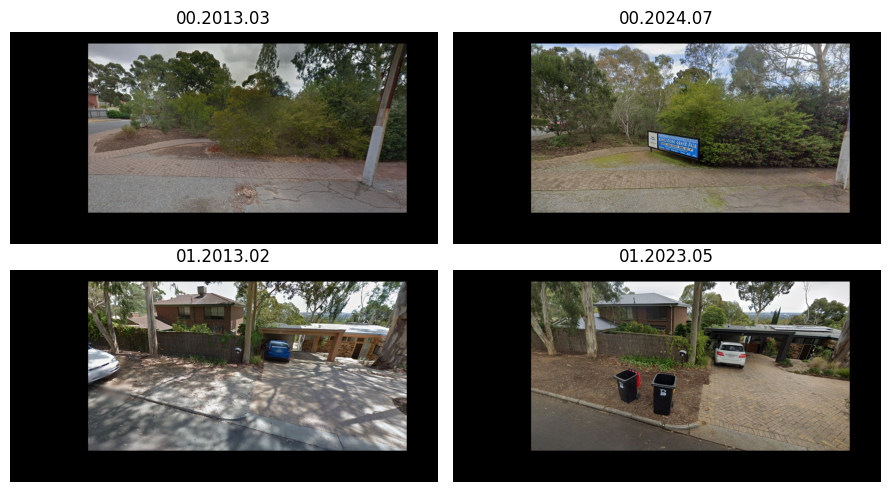

In [5]:
kwargs = {
    "layer": [0, 0, 0],  # black color
    "ratio": 0.0,
    "mask": roi,
}

masked_t0_0 = utils_img.overlay_image(t0_0, **kwargs)
masked_t1_0 = utils_img.overlay_image(t1_0, **kwargs)
masked_t0_1 = utils_img.overlay_image(t0_1, **kwargs)
masked_t1_1 = utils_img.overlay_image(t1_1, **kwargs)

fig, ax = plt.subplots(2, 2, figsize=(9, 5))

ax[0, 0].imshow(masked_t0_0)
ax[0, 1].imshow(masked_t1_0)
ax[1, 0].imshow(masked_t0_1)
ax[1, 1].imshow(masked_t1_1)

ax[0, 0].set_title("00.2013.03")
ax[0, 1].set_title("00.2024.07")
ax[1, 0].set_title("01.2013.02")
ax[1, 1].set_title("01.2023.05")

# remove axis
for a in ax.ravel():
    a.axis("off")

plt.tight_layout()

In [6]:
# we have pre-processed the screenshots as dinov2 only accepts 14n * 14m

H, W = masked_t0_0.shape[:2]

print(H, W)
print(H % 14, W % 14)

952 1918
0 0


---
get model

In [7]:
root = "../../checkpoints"
checkpoint = os.path.join(root, "dinov2.2CrossAttn.CMU.pth")
checkpoint = torch.load(checkpoint)

# manually update the shape of the input
# it will be updated in the next version
checkpoint["args"]["model"]["target-shp-row"] = H
checkpoint["args"]["model"]["target-shp-col"] = W
checkpoint["args"]["model"]

{'name': 'dino2 + cross_attention',
 'dino-model': 'dinov2_vits14',
 'layer1': 11,
 'facet1': 'query',
 'facet2': 'query',
 'num-heads': 1,
 'dropout-rate': 0.1,
 'target-shp-row': 952,
 'target-shp-col': 1918,
 'num-blocks': 1,
 'freeze-dino': True,
 'unfreeze-dino-last-n-layer': 0}

In [8]:
# form the model
model = models.get_model(**checkpoint["args"]["model"])
model = nn.DataParallel(model).cuda()
model = utils_torch.load_grad_required_state(model, checkpoint["model"])
model = model.eval()

Using cache found in /home/chad/.cache/torch/hub/facebookresearch_dinov2_main
A matching Triton is not available, some optimizations will not be enabled.
Error caught was: No module named 'triton'


<All keys matched successfully>


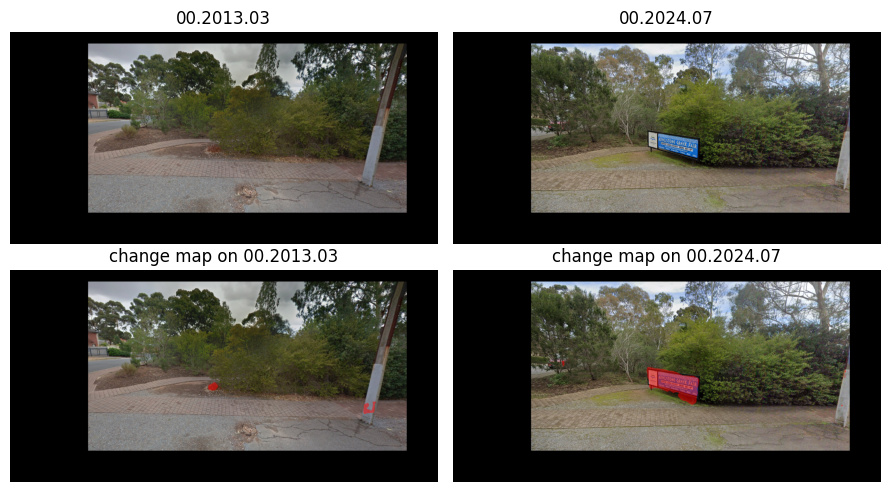

In [9]:
# inference on 00
tensor_0 = torch.from_numpy(masked_t0_0).permute(2, 0, 1).unsqueeze(0)
tensor_0 = tensor_0.float().cuda()

tensor_1 = torch.from_numpy(masked_t1_0).permute(2, 0, 1).unsqueeze(0)
tensor_1 = tensor_1.float().cuda()

with torch.no_grad():
    pred_0 = model(tensor_0, tensor_1)  # 1, H, W, 2
    pred_1 = model(tensor_1, tensor_0)  # 1, H, W, 2

    pred_0 = torch.argmax(pred_0, dim=-1).squeeze().cpu().numpy()
    pred_1 = torch.argmax(pred_1, dim=-1).squeeze().cpu().numpy()

fig, ax = plt.subplots(2, 2, figsize=(9, 5))

ax[0, 0].imshow(masked_t0_0)
ax[0, 1].imshow(masked_t1_0)
ax[1, 0].imshow(utils_img.overlay_image(masked_t0_0, [1, 0, 0], mask=pred_0))
ax[1, 1].imshow(utils_img.overlay_image(masked_t1_0, [1, 0, 0], mask=pred_1))

ax[0, 0].set_title("00.2013.03")
ax[0, 1].set_title("00.2024.07")
ax[1, 0].set_title("change map on 00.2013.03")
ax[1, 1].set_title("change map on 00.2024.07")

# remove axis
for a in ax.ravel():
    a.axis("off")

plt.tight_layout()

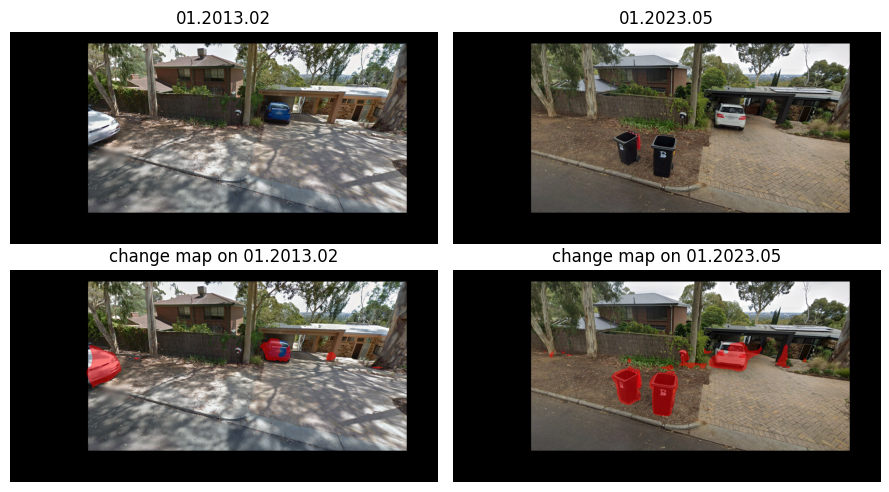

In [10]:
# inference on 01
tensor_0 = torch.from_numpy(masked_t0_1).permute(2, 0, 1).unsqueeze(0)
tensor_0 = tensor_0.float().cuda()

tensor_1 = torch.from_numpy(masked_t1_1).permute(2, 0, 1).unsqueeze(0)
tensor_1 = tensor_1.float().cuda()

with torch.no_grad():
    pred_0 = model(tensor_0, tensor_1)  # 1, H, W, 2
    pred_1 = model(tensor_1, tensor_0)  # 1, H, W, 2

    pred_0 = torch.argmax(pred_0, dim=-1).squeeze().cpu().numpy()
    pred_1 = torch.argmax(pred_1, dim=-1).squeeze().cpu().numpy()

fig, ax = plt.subplots(2, 2, figsize=(9, 5))

ax[0, 0].imshow(masked_t0_1)
ax[0, 1].imshow(masked_t1_1)
ax[1, 0].imshow(utils_img.overlay_image(masked_t0_1, [1, 0, 0], mask=pred_0))
ax[1, 1].imshow(utils_img.overlay_image(masked_t1_1, [1, 0, 0], mask=pred_1))


ax[0, 0].set_title("01.2013.02")
ax[0, 1].set_title("01.2023.05")
ax[1, 0].set_title("change map on 01.2013.02")
ax[1, 1].set_title("change map on 01.2023.05")

# remove axis
for a in ax.ravel():
    a.axis("off")

plt.tight_layout()